In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Optional, Union, List, Dict
from pathlib import Path
from dataclasses import dataclass, field
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                           roc_auc_score, confusion_matrix, classification_report,
                           roc_curve, precision_recall_curve)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin
from tqdm import tqdm
import joblib
from catboost import CatBoostClassifier
import os
import warnings
import netCDF4
import pyarrow as pa
import pyarrow.parquet as pq

import netCDF4
import numpy as np
import pandas as pd
import geopandas as gpd

from datetime import datetime, timedelta
from tqdm import tqdm
from shapely.geometry import Point

from scipy.stats import skew, kurtosis, entropy

from scipy.fft import fft
from sklearn.preprocessing import MinMaxScaler

from catboost import CatBoostClassifier
from joblib import load

import os




from sklearn.metrics import roc_curve
import seaborn as sns

import pandas as pd


from collections import Counter
warnings.filterwarnings('ignore')



# Configurazione per grafici migliori
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12


In [43]:
class NetCDFPreprocessor:
    def __init__(self, root_dir, preprocessing_method=str):
        self.root_dir = root_dir
        self.netcdf_file_list = os.listdir(root_dir)
        self.preprocessing_method = preprocessing_method
        if self.preprocessing_method not in ['filtered', 'with_lat_lons', 'unfiltered']:
            raise ValueError("Invalid preprocessing method. Choose from 'filtered', 'with_lat_lons', or 'unfiltered'.")

    @staticmethod
    def check_integrity(f):
        """Check integrity of the netCDF file"""
        if not isinstance(f, netCDF4.Dataset):
            raise ValueError("Input must be a netCDF4.Dataset object")
        if 'raw_counts' not in f.variables:
            raise KeyError("The netCDF file does not contain 'raw_counts' variable")
        if 'sp_alt' not in f.variables or 'sp_inc_angle' not in f.variables:
            raise KeyError("The netCDF file does not contain 'sp_alt' or 'sp_inc_angle' variables")
        if 'sp_rx_gain_copol' not in f.variables or 'sp_rx_gain_xpol' not in f.variables or 'ddm_snr' not in f.variables:
            raise KeyError("The netCDF file does not contain 'sp_rx_gain_copol', 'sp_rx_gain_xpol' or 'ddm_snr' variables")
        if 'sp_lat' not in f.variables or 'sp_lon' not in f.variables:
            raise KeyError("The netCDF file does not contain 'sp_lat' or 'sp_lon' variables")
        if 'sp_surface_type' not in f.variables:
            raise KeyError("The netCDF file does not contain 'sp_surface_type' variable")
        if 'ac_alt' not in f.variables:
            raise KeyError("The netCDF file does not contain 'ac_alt' variable")
        if f.variables['raw_counts'].ndim != 4:
            raise ValueError("The 'raw_counts' variable must have 4 dimensions")
        
    def preprocess(self, f):
        """ Preprocess the netCDF file and return fit data and labels """
        # Check integrity of the netCDF file
        self.check_integrity(f)
        
        # Carica i dati una volta sola, evitando np.array() non necessario
        raw_counts = f.variables['raw_counts'][:]
        
        # Ottimizzazione 1: Usa broadcasting invece di repeat
        ac_alt = f.variables['ac_alt'][:]
        sp_alt = f.variables['sp_alt'][:]
        sp_inc_angle = f.variables['sp_inc_angle'][:]
        
        # Broadcasting più efficiente (evita repeat)
        distance_2d = (ac_alt[:, np.newaxis] - sp_alt) / np.cos(np.deg2rad(sp_inc_angle))
        
        # Carica tutte le variabili necessarie
        copol = f.variables['sp_rx_gain_copol'][:]
        xpol = f.variables['sp_rx_gain_xpol'][:]
        snr = f.variables['ddm_snr'][:]
        
        
        keep_mask = (
            (copol >= 5) & 
            (xpol >= 5) & 
            (snr > 0) & 
            (distance_2d >= 2000) & 
            (distance_2d <= 10000) &
            ~np.isnan(copol) & 
            ~np.isnan(xpol) & 
            ~np.isnan(snr) & 
            ~np.isnan(distance_2d)
        )
        
        output_array = np.full(raw_counts.shape, np.nan, dtype=np.float32)
        i_indices, j_indices = np.where(keep_mask)
        output_array[i_indices, j_indices] = raw_counts[i_indices, j_indices]
        
        n_time, n_samples = raw_counts.shape[:2]
        raw_counts_reshaped = output_array.reshape(n_time * n_samples, *raw_counts.shape[2:])
        
        valid_mask = ~np.any(np.isnan(raw_counts_reshaped), axis=(1, 2)) & (np.sum(raw_counts_reshaped, axis=(1, 2)) > 0)
        
        fit_data = raw_counts_reshaped[valid_mask].reshape(valid_mask.sum(), -1)
        
        surface_types = np.nan_to_num(f.variables["sp_surface_type"][:], nan=0).ravel()
        label_data = np.isin(surface_types, np.arange(1, 8)).astype(np.int32)
        label_data = label_data[valid_mask]
        
        assert fit_data.shape[0] == len(label_data), \
            f"Shape mismatch: fit_data {fit_data.shape[0]}, label_data {len(label_data)}"
        
        return fit_data, label_data
    
    def preprocess_w_lat_lons(self, f):
        """ Version with latitude and longitude extraction """

        self.check_integrity(f)
        raw_counts = np.array(f.variables['raw_counts'])
                
        # Calcolo distanza tra il punto speculare e l'aereo
        ac_alt_2d = np.repeat(np.array(f.variables['ac_alt'])[:, np.newaxis], 20, axis=1)
        distance_2d = (ac_alt_2d - f.variables['sp_alt'][:]) / np.cos(np.deg2rad(f.variables['sp_inc_angle'][:]))

        # Seleziono gli indici dove sp_rx_gain_copol > 5, sp_rx_gain_xpol > 5 e ddm_snr > 0 e distanza tra punto speculare e antenna > 2000 e < 10000

        copol = f.variables['sp_rx_gain_copol'][:]
        xpol = f.variables['sp_rx_gain_xpol'][:]
        snr = f.variables['ddm_snr'][:]
        dist = distance_2d[:]
        specular_point_lat = f.variables['sp_lat'][:]
        specular_point_lon = f.variables['sp_lon'][:]

        # Filtraggio dei dati
        keep_mask = (copol >= 5) & (xpol >= 5) & (snr > 0) & ((dist >= 2000) & (dist <= 10000)) & (~np.isnan(copol.data) & ~np.isnan(xpol.data) & ~np.isnan(snr.data) & ~np.isnan(dist.data) & ~np.isnan(specular_point_lat.data) & ~np.isnan(specular_point_lon.data))
        to_keep_indices = np.argwhere(keep_mask)
        
        filtered_raw_counts = [raw_counts[i, j] for i, j in to_keep_indices]
        output_array = np.full(raw_counts.shape, np.nan, dtype=np.float32)

        specular_point_lats = specular_point_lat[to_keep_indices[:, 0]]
        specular_point_lons = specular_point_lon[to_keep_indices[:, 0]]
        
        for idx, (i, j) in enumerate(to_keep_indices):
            output_array[i, j] = filtered_raw_counts[idx]
                
            raw_counts_filtered = output_array.copy()

        raw_counts_filtered = output_array.copy()
        del output_array

        ddm_data_dict = {
            'Raw_Counts': raw_counts_filtered.reshape(raw_counts_filtered.shape[0]*raw_counts_filtered.shape[1], raw_counts_filtered.shape[2], raw_counts_filtered.shape[3]),
        }

        keep_indices = np.where(
            np.all(~np.isnan(ddm_data_dict['Raw_Counts']), axis=(1, 2)) & (np.sum(ddm_data_dict['Raw_Counts'], axis=(1, 2)) > 0)
        )[0]
        fit_data = np.array([ddm_data_dict['Raw_Counts'][f].ravel() for f in keep_indices])

        specular_point_lats = specular_point_lat.ravel()[keep_indices]
        specular_point_lons = specular_point_lon.ravel()[keep_indices]
        
        surface_types = f.variables["sp_surface_type"][:]
        surface_types = np.nan_to_num(surface_types, nan=0)
        surface_types_unravelled = surface_types.ravel()
        label_data = [1 if surface_type in np.arange(1, 8) else 0 for surface_type in surface_types_unravelled]
        label_data = [label_data[lab] for lab in range(len(label_data)) if lab in keep_indices]

        assert np.array(fit_data).shape[0] == len(label_data) == np.array(specular_point_lats).shape[0] == np.array(specular_point_lons).shape[0], \
            f"Shape mismatch: fit_data {np.array(fit_data).shape[0]}, label_data {len(label_data)}, lats {np.array(specular_point_lats).shape[0]}, lons {np.array(specular_point_lons).shape[0]}"
        

        return fit_data, label_data, specular_point_lats, specular_point_lons
    
    def preprocess_snr_unfiltered(self, f):
        """ Preprocess the netCDF file and return fit data and labels without filtering on signal-to-noise ratio """
        # Check integrity of the netCDF file
        self.check_integrity(f)
        
        # Carica i dati una volta sola, evitando np.array() non necessario
        raw_counts = f.variables['raw_counts'][:]
        
        # Ottimizzazione 1: Usa broadcasting invece di repeat
        ac_alt = f.variables['ac_alt'][:]
        sp_alt = f.variables['sp_alt'][:]
        sp_inc_angle = f.variables['sp_inc_angle'][:]
        
        
        distance_2d = (ac_alt[:, np.newaxis] - sp_alt) / np.cos(np.deg2rad(sp_inc_angle))
        
        # Carica tutte le variabili necessarie
        copol = f.variables['sp_rx_gain_copol'][:]
        xpol = f.variables['sp_rx_gain_xpol'][:]
        #snr = f.variables['ddm_snr'][:]
        
        
        keep_mask = (
            (copol >= 5) & 
            (xpol >= 5) & 
        #   (snr > 0) & ELiminato filtraggio su Signal-to-Noise Ratio 
            (distance_2d >= 2000) & 
            (distance_2d <= 10000) &
            ~np.isnan(copol) & 
            ~np.isnan(xpol) & 
            #~np.isnan(snr) & 
            ~np.isnan(distance_2d)
        )
        
        output_array = np.full(raw_counts.shape, np.nan, dtype=np.float32)
        i_indices, j_indices = np.where(keep_mask)
        output_array[i_indices, j_indices] = raw_counts[i_indices, j_indices]
        
        n_time, n_samples = raw_counts.shape[:2]
        raw_counts_reshaped = output_array.reshape(n_time * n_samples, *raw_counts.shape[2:])
        
        valid_mask = ~np.any(np.isnan(raw_counts_reshaped), axis=(1, 2)) & (np.sum(raw_counts_reshaped, axis=(1, 2)) > 0)
        
        fit_data = raw_counts_reshaped[valid_mask].reshape(valid_mask.sum(), -1)
        
        surface_types = np.nan_to_num(f.variables["sp_surface_type"][:], nan=0).ravel()
        label_data = np.isin(surface_types, np.arange(1, 8)).astype(np.int32)
        label_data = label_data[valid_mask]
        
        assert fit_data.shape[0] == len(label_data), \
            f"Shape mismatch: fit_data {fit_data.shape[0]}, label_data {len(label_data)}"
        
        return fit_data, label_data


    def process_all_files_random_picked(self, chunk_size = int, sample_fraction = float, n_files_to_pick= int, remove_chunks= bool):
        
        full_data = []
        full_labels = []
        counter = 0
        # Prendi 500 file random dalla lista dei file netCDF
        if int(len(self.netcdf_file_list)) > n_files_to_pick:
            np.random.seed(42)
            random_netcdf_selected_files = np.random.choice(self.netcdf_file_list, n_files_to_pick, replace=False)
            print('Selezionati 500 file netCDF casuali dalla lista')
        else:
            random_netcdf_selected_files = self.netcdf_file_list

        for file_name in tqdm(random_netcdf_selected_files, desc="Processing files"):
            if not file_name.endswith('.nc'):
                continue
            try:
                f = netCDF4.Dataset(f'{self.root_dir}{file_name}')
                if self.preprocessing_method == 'unfiltered':
                    data, labels = self.preprocess_snr_unfiltered(f)
                elif self.preprocessing_method == 'with_lat_lons':
                    data, labels, latitudes, longitudes = self.preprocess_w_lat_lons(f)
                else:
                    # Default to filtered preprocessing
                    data, labels = self.preprocess(f)
                assert (len(data) == len(labels)), f"Data and labels length mismatch in file {file_name}: {len(data)} != {len(labels)}"
                full_data.append(data)
                full_labels.append(labels)
            except Exception as e:
                print(f"Error processing file {file_name}: {e}")
                continue
            counter += 1
            if counter == n_files_to_pick:
                break  # Limita il numero di file processati per test
                
        # Trova gli indici degli elementi di full_data con seconda dimensione uguale a 200
        valid_indices = [i for i, arr in enumerate(full_data) if arr.ndim == 2 if arr.shape[1] == 200]

        # Applica la selezione a full_data e full_labels
        full_data_clean = [full_data[i] for i in valid_indices]
        full_labels_clean = [full_labels[i] for i in valid_indices]
        
        # Chunking 
        os.makedirs('test_data/binary_classification', exist_ok=True)

        chunk_size = chunk_size # dimensione del chunk in numero di campioni
        sample_fraction = sample_fraction # frazione di dati da campionare per ogni chunk

        full_data_sampled = []
        full_labels_sampled = []

        num_chunks = int(np.ceil(len(full_data_clean) / chunk_size))
        print(f"Total number of chunks: {num_chunks}")
        for idx in range(num_chunks):
            start = idx * chunk_size
            end = min((idx + 1) * chunk_size, len(full_data_clean))
            chunk_data = np.vstack(full_data_clean[start:end])
            chunk_labels = np.hstack(full_labels_clean[start:end])
            
            print(f"Chunk {idx + 1}/{num_chunks} processed with shape {chunk_data.shape} and labels shape {chunk_labels.shape}")

            # Salva ogni chunk come file parquet separato
            fit_data_df = pd.DataFrame(chunk_data)
            labels_df = pd.DataFrame(chunk_labels, columns=['label'])

            table_fit = pa.Table.from_pandas(fit_data_df, preserve_index=False)
            table_labels = pa.Table.from_pandas(labels_df, preserve_index=False)

            pq.write_table(
                table_fit,
                f'test_data/binary_classification/fit_data_chunk_{idx}.parquet',
                compression='zstd',
                use_dictionary=True,
            )
            pq.write_table(
                table_labels,
                f'test_data/binary_classification/labels_chunk_{idx}.parquet',
                compression='zstd',
                use_dictionary=True,
            )
            
        # Imposta la frazione di dati da campionare per ogni chunk (es: 0.2 per il 20%)
        
            _, X_sampled, _, y_sampled = train_test_split(
                chunk_data, chunk_labels, 
                test_size=sample_fraction, 
                stratify=chunk_labels, 
                random_state=42
            )

            
            full_data_sampled.append(X_sampled)
            full_labels_sampled.append(y_sampled)

        del full_data, full_labels

        full_data_sampled_stratified = np.vstack(full_data_sampled)
        full_labels_sampled_stratified = np.hstack(full_labels_sampled)

        del full_data_sampled, full_labels_sampled
        print(f"Shape of sampled data after chunking and sampling: {np.array(full_data_sampled_stratified).shape}")
        print(f"Shape of sampled labels after chunking and sampling: {np.array(full_labels_sampled_stratified).shape}")
        
        # Crea la cartella test_data se non esiste
        os.makedirs('test_data/binary_classification', exist_ok=True)

        # Salva fit_data in formato parquet 
        fit_data_df = pd.DataFrame(full_data_sampled_stratified)
        table_fit = pa.Table.from_pandas(fit_data_df, preserve_index=False)
        pq.write_table(
            table_fit,
            'test_data/binary_classification/fit_data_binary_test.parquet',
            compression='zstd',
            use_dictionary=True,
            
        )

        # Salva labels in formato parquet 
        labels_df = pd.DataFrame(full_labels_sampled_stratified, columns=['label'])
        table_labels = pa.Table.from_pandas(labels_df, preserve_index=False)
        pq.write_table(
            table_labels,
            'test_data/binary_classification/labels_binary_test.parquet',
            compression='zstd',
            use_dictionary=True,
            
        )
        del fit_data_df, labels_df, table_fit, table_labels
        
        print("Data and labels saved in test_data/binary_classification directory.")
        # Remove all chunk parquet files if flag is set
        if remove_chunks:
            try:
                chunk_dir = 'test_data/binary_classification'
                for fname in os.listdir(chunk_dir):
                    if fname.startswith('fit_data_chunk_') or fname.startswith('labels_chunk_'):
                        os.remove(os.path.join(chunk_dir, fname))
                print("All chunk files removed.")
            except Exception as e:
                print(f"Error removing chunk files: {e}")

        return full_data_sampled_stratified, full_labels_sampled_stratified
    


class DDMFeatureExtractor:
    def __init__(self):
        pass
    def gini(self, array):
            """Calcola il coefficiente di Gini (disuguaglianza)"""
            array = np.sort(array)
            index = np.arange(1, array.shape[0] + 1)
            return (np.sum((2 * index - array.shape[0] - 1) * array)) / (array.shape[0] * np.sum(array))    
    def extract_ddm_features(self, fit_data: np.ndarray) -> pd.DataFrame:

        """
        Estrae features dettagliate da raw_counts DDM (shape: n_samples x 200)
        """
        features = []

        for row in tqdm(fit_data, desc="Extracting DDM features"):
            f = {}
            x = np.array(row, dtype=np.float64) + 1e-10  # evita log(0)

            # 1. Statistiche base
            f['mean'] = np.mean(x)
            f['std'] = np.std(x)
            f['min'] = np.min(x)
            f['max'] = np.max(x)
            f['median'] = np.median(x)
            f['range'] = np.max(x) - np.min(x)
            f['skew'] = skew(x)
            f['kurtosis'] = kurtosis(x)
            f['entropy'] = entropy(x)
            f['gini'] = self.gini(x)

            # 2. Posizionali
            f['peak_index'] = np.argmax(x)
            f['peak_value'] = np.max(x)
            f['center_of_mass'] = np.sum(np.arange(len(x)) * x) / np.sum(x)
            f['inertia'] = np.sum(((np.arange(len(x)) - f['center_of_mass'])**2) * x)

            # 3. Segmentazione
            thirds = np.array_split(x, 3)
            for i, part in enumerate(thirds):
                f[f'sum_third_{i+1}'] = np.sum(part)
                f[f'mean_third_{i+1}'] = np.mean(part)
                f[f'max_third_{i+1}'] = np.max(part)
            
            windows = np.array_split(x, 5)
            for i, w in enumerate(windows):
                f[f'mean_w{i+1}'] = np.mean(w)
                f[f'std_w{i+1}'] = np.std(w)
                f[f'max_w{i+1}'] = np.max(w)

            # 4. Derivate e cambiamenti
            dx = np.diff(x)
            f['mean_diff'] = np.mean(dx)
            f['std_diff'] = np.std(dx)
            f['max_diff'] = np.max(dx)
            f['min_diff'] = np.min(dx)
            f['n_positive_diff'] = np.sum(dx > 0)
            f['n_negative_diff'] = np.sum(dx < 0)
            f['n_zero_diff'] = np.sum(dx == 0)

            # 5. Autocorrelazioni (lag 1-3)
            for lag in range(1, 4):
                ac = np.corrcoef(x[:-lag], x[lag:])[0, 1] if len(x) > lag else np.nan
                f[f'autocorr_lag{lag}'] = ac

            # 6. FFT (spettro frequenze)
            spectrum = np.abs(fft(x))
            half_spectrum = spectrum[:len(spectrum)//2]  # simmetrico
            f['fft_peak_freq'] = np.argmax(half_spectrum)
            f['fft_max'] = np.max(half_spectrum)
            f['fft_median'] = np.median(half_spectrum)
            f['fft_mean'] = np.mean(half_spectrum)

            
            #Aggiungi le statistiche dei quadranti e del centro
            ddm = row.reshape(10, 20)  # 10x20

            # Quadranti
            q1 = ddm[:5, :10].ravel()
            q2 = ddm[:5, 10:].ravel()
            q3 = ddm[5:, :10].ravel()
            q4 = ddm[5:, 10:].ravel()
            # Quadrante centrale (4x8 centrale)
            center = ddm[3:7, 6:14].ravel()
            
            # Statistiche dei quadranti 
            f['q1_mean'] = np.mean(q1)
            f['q2_mean'] = np.mean(q2)      
            f['q3_mean'] = np.mean(q3)
            f['q4_mean'] = np.mean(q4)
            f['center_mean'] = np.mean(center)
            f['q1_std'] = np.std(q1)
            f['q2_std'] = np.std(q2)
            f['q3_std'] = np.std(q3)
            f['q4_std'] = np.std(q4)
            f['center_std'] = np.std(center)
            f['q1_min'] = np.min(q1)
            f['q2_min'] = np.min(q2)
            f['q3_min'] = np.min(q3)
            f['q4_min'] = np.min(q4)
            f['center_min'] = np.min(center)
            f['q1_max'] = np.max(q1)
            f['q2_max'] = np.max(q2)
            f['q3_max'] = np.max(q3)
            f['q4_max'] = np.max(q4)
            f['center_max'] = np.max(center)
            f['q1_median'] = np.median(q1)
            f['q2_median'] = np.median(q2)
            f['q3_median'] = np.median(q3)
            f['q4_median'] = np.median(q4)
            f['center_median'] = np.median(center)
            f['q1_range'] = np.max(q1) - np.min(q1)
            f['q2_range'] = np.max(q2) - np.min(q2)
            f['q3_range'] = np.max(q3) - np.min(q3)
            f['q4_range'] = np.max(q4) - np.min(q4)
            f['center_range'] = np.max(center) - np.min(center)
            f['q1_skew'] = skew(q1)
            f['q2_skew'] = skew(q2)
            f['q3_skew'] = skew(q3)
            f['q4_skew'] = skew(q4)
            f['center_skew'] = skew(center)
            f['q1_kurtosis'] = kurtosis(q1)
            f['q2_kurtosis'] = kurtosis(q2)
            f['q3_kurtosis'] = kurtosis(q3)
            f['q4_kurtosis'] = kurtosis(q4)
            f['center_kurtosis'] = kurtosis(center)
            f['q1_entropy'] = entropy(q1 + 1e-10)
            f['q2_entropy'] = entropy(q2 + 1e-10)
            f['q3_entropy'] = entropy(q3 + 1e-10)
            f['q4_entropy'] = entropy(q4 + 1e-10)
            f['center_entropy'] = entropy(center + 1e-10)
            f['q1_gini'] = self.gini(q1)
            f['q2_gini'] = self.gini(q2)
            f['q3_gini'] = self.gini(q3)
            f['q4_gini'] = self.gini(q4)
            f['center_gini'] = self.gini(center)

            # Statistiche di confronto tra quadranti e centro
            
            # Differenze tra media dei quadranti e centro
            f['q1_center_mean_diff'] = f['q1_mean'] - f['center_mean']
            f['q2_center_mean_diff'] = f['q2_mean'] - f['center_mean']
            f['q3_center_mean_diff'] = f['q3_mean'] - f['center_mean']
            f['q4_center_mean_diff'] = f['q4_mean'] - f['center_mean']

            # Differenze tra std dei quadranti e centro
            f['q1_center_std_diff'] = f['q1_std'] - f['center_std']
            f['q2_center_std_diff'] = f['q2_std'] - f['center_std']
            f['q3_center_std_diff'] = f['q3_std'] - f['center_std']
            f['q4_center_std_diff'] = f['q4_std'] - f['center_std']

            # Differenze tra max dei quadranti e centro
            f['q1_center_max_diff'] = f['q1_max'] - f['center_max']
            f['q2_center_max_diff'] = f['q2_max'] - f['center_max']
            f['q3_center_max_diff'] = f['q3_max'] - f['center_max']
            f['q4_center_max_diff'] = f['q4_max'] - f['center_max']

            # Differenze tra min dei quadranti e centro
            f['q1_center_min_diff'] = f['q1_min'] - f['center_min']
            f['q2_center_min_diff'] = f['q2_min'] - f['center_min']
            f['q3_center_min_diff'] = f['q3_min'] - f['center_min']
            f['q4_center_min_diff'] = f['q4_min'] - f['center_min']

            # Differenze tra entropia dei quadranti e centro
            f['q1_center_entropy_diff'] = f['q1_entropy'] - f['center_entropy']
            f['q2_center_entropy_diff'] = f['q2_entropy'] - f['center_entropy']
            f['q3_center_entropy_diff'] = f['q3_entropy'] - f['center_entropy']
            f['q4_center_entropy_diff'] = f['q4_entropy'] - f['center_entropy']

            # Differenze tra gini dei quadranti e centro
            f['q1_center_gini_diff'] = f['q1_gini'] - f['center_gini']
            f['q2_center_gini_diff'] = f['q2_gini'] - f['center_gini']
            f['q3_center_gini_diff'] = f['q3_gini'] - f['center_gini']
            f['q4_center_gini_diff'] = f['q4_gini'] - f['center_gini']

            # Differenze tra skewness dei quadranti e centro
            f['q1_center_skew_diff'] = f['q1_skew'] - f['center_skew']
            f['q2_center_skew_diff'] = f['q2_skew'] - f['center_skew']
            f['q3_center_skew_diff'] = f['q3_skew'] - f['center_skew']
            f['q4_center_skew_diff'] = f['q4_skew'] - f['center_skew']

            # Differenze tra kurtosis dei quadranti e centro
            f['q1_center_kurtosis_diff'] = f['q1_kurtosis'] - f['center_kurtosis']
            f['q2_center_kurtosis_diff'] = f['q2_kurtosis'] - f['center_kurtosis']
            f['q3_center_kurtosis_diff'] = f['q3_kurtosis'] - f['center_kurtosis']
            f['q4_center_kurtosis_diff'] = f['q4_kurtosis'] - f['center_kurtosis']

            features.append(f)
            
        return features

In [44]:
@dataclass
class SampleConfig:
    """Configurazione per un singolo campionamento."""
    name: str
    n_samples_per_class: int
    random_state: int = 42


@dataclass
class DatasetInfo:
    """Informazioni sul dataset."""
    n_samples: int
    n_features: int
    class_distribution: Dict[int, int]
    features_columns: List[str]
    labels_columns: List[str]


@dataclass
class DataLoader:
    features_path: Union[str, Path]
    labels_path: Union[str, Path]
    _features_df_cache: Optional[pd.DataFrame] = field(default=None, init=False, repr=False)
    _labels_df_cache: Optional[pd.DataFrame] = field(default=None, init=False, repr=False)
    
    def __post_init__(self):
        """Converte i path in oggetti Path e verifica che esistano."""
        self.features_path = Path(self.features_path)
        self.labels_path = Path(self.labels_path)
        
        if not self.features_path.exists():
            raise FileNotFoundError(f"Features file not found: {self.features_path}")
        if not self.labels_path.exists():
            raise FileNotFoundError(f"Labels file not found: {self.labels_path}")
    
    def load_full_data(self, use_cache: bool = False) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """
        Carica tutti i dati senza campionamento.
        
        Args:
            use_cache: Se True, usa i dati in cache se disponibili
            
        Returns:
            Tuple[pd.DataFrame, pd.DataFrame]: features_df, labels_df
        """
        if use_cache and self._features_df_cache is not None and self._labels_df_cache is not None:
            return self._features_df_cache, self._labels_df_cache
        
        features_df = pd.read_parquet(self.features_path)
        labels_df = pd.read_parquet(self.labels_path)
        
        # Verifica che abbiano lo stesso numero di righe
        if len(features_df) != len(labels_df):
            raise ValueError(f"Features and labels have different lengths: "
                           f"{len(features_df)} vs {len(labels_df)}")
        
        if use_cache:
            self._features_df_cache = features_df
            self._labels_df_cache = labels_df
        
        return features_df, labels_df
    
    def clear_cache(self) -> None:
        """Pulisce la cache dei dati."""
        self._features_df_cache = None
        self._labels_df_cache = None
    
    def load_balanced_sample(self, n_samples_per_class: int, 
                           random_state: int = 42,
                           use_cache: bool = False) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """
        Carica un campione bilanciato dei dati.
            
        Returns:
            Tuple[pd.DataFrame, pd.DataFrame]: features_df campionate, labels_df campionate
        """
        # Carica i dati completi
        features_df_full, labels_df_full = self.load_full_data(use_cache=use_cache)
        
        # Ottieni gli indici campionati in modo bilanciato
        sampled_indices = self._get_balanced_indices(
            labels_df_full, 
            n_samples_per_class, 
            random_state
        )
        
        # Campiona i dati
        features_df = features_df_full.loc[sampled_indices].reset_index(drop=True)
        labels_df = labels_df_full.loc[sampled_indices].reset_index(drop=True)
        
        return features_df, labels_df
    
    def load_balanced_sample_memory_efficient(self, n_samples_per_class: int, 
                                            random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """
        Versione memory-efficient che libera la memoria dopo il campionamento.
        
        Args:
            n_samples_per_class: Numero di campioni per ogni classe
            random_state: Seed per la riproducibilità
            
        Returns:
            Tuple[pd.DataFrame, pd.DataFrame]: features_df campionate, labels_df campionate
        """
        # Carica i dati completi (senza cache)
        features_df_full = pd.read_parquet(self.features_path)
        labels_df_full = pd.read_parquet(self.labels_path)
        
        # Ottieni gli indici campionati
        sampled_indices = self._get_balanced_indices(
            labels_df_full, 
            n_samples_per_class, 
            random_state
        )
        
        # Campiona i dati
        features_df = features_df_full.loc[sampled_indices].reset_index(drop=True)
        labels_df = labels_df_full.loc[sampled_indices].reset_index(drop=True)
        
        # Libera la memoria
        del features_df_full, labels_df_full, sampled_indices
        
        return features_df, labels_df
    

    
    def _get_balanced_indices(self, labels_df: pd.DataFrame, 
                            n_samples_per_class: int, 
                            random_state: int) -> pd.Index:
        """
        Ottiene gli indici per un campionamento bilanciato.
        
        Args:
            labels_df: DataFrame delle labels
            n_samples_per_class: Numero di campioni per classe
            random_state: Seed per la riproducibilità
            
        Returns:
            pd.Index: Indici campionati
        """
        # Usa la prima colonna per il groupby (assumendo sia la colonna delle classi)
        label_column = labels_df.iloc[:, 0]
        
        # Verifica che ci siano abbastanza campioni per ogni classe
        class_counts = label_column.value_counts()
        for class_label, count in class_counts.items():
            if count < n_samples_per_class:
                raise ValueError(f"Class {class_label} has only {count} samples, "
                               f"but {n_samples_per_class} requested")
        
        # Campiona gli indici
        sampled_indices = (
            labels_df.groupby(label_column)
            .apply(lambda x: x.sample(n=n_samples_per_class, random_state=random_state))
            .index.get_level_values(1)
        )
        
        return sampled_indices

In [45]:
ROOT_DIR = 'E:/data/RONGOWAI_L1_SDR_V1.0/'

In [48]:
read_from_backup = False
if read_from_backup:
    
    # Leggi i file parquet con polars
    fit_data_pl = pd.read_parquet('C:/Users/atogni/Desktop/rongowai/test_data/binary_classification/fit_data_binary_test.parquet')
    labels_pl = pd.read_parquet('C:/Users/atogni/Desktop/rongowai/test_data/binary_classification/labels_binary_test.parquet')

    # Trasforma in numpy array
    fit_data = fit_data_pl.to_numpy()
    labels = labels_pl['label'].to_numpy()
    del fit_data_pl, labels_pl
else:
    preprocessor = NetCDFPreprocessor(root_dir=ROOT_DIR, preprocessing_method='filtered')
    fit_data, labels = preprocessor.process_all_files_random_picked(chunk_size=250, n_files_to_pick= 1000, sample_fraction=0.9,remove_chunks=True)

Selezionati 500 file netCDF casuali dalla lista


Processing files:   4%|▍         | 40/1000 [00:04<01:34, 10.16it/s]

Error processing file 20250212-195305_NZAA-NZWR_L1.nc: cannot reshape array of size 0 into shape (0,newaxis)


Processing files:  16%|█▋        | 163/1000 [00:17<01:28,  9.48it/s]

Error processing file 20240927-100501_NZHK-NZCH_L1.nc: cannot reshape array of size 0 into shape (0,newaxis)


Processing files:  31%|███       | 311/1000 [00:34<01:22,  8.38it/s]

Error processing file 20241218-201112_NZWN-NZTG_L1.nc: cannot reshape array of size 0 into shape (0,newaxis)


Processing files:  54%|█████▍    | 538/1000 [01:00<00:44, 10.44it/s]

Error processing file 20240913-073059_NZWB-NZWN_L1.nc: cannot reshape array of size 0 into shape (0,newaxis)


Processing files:  55%|█████▍    | 547/1000 [01:01<00:51,  8.85it/s]

Error processing file 20250212-174656_NZWB-NZAA_L1.nc: cannot reshape array of size 0 into shape (0,newaxis)


Processing files:  60%|██████    | 605/1000 [01:07<00:38, 10.19it/s]

Error processing file 20240926-121247_NZNV-NZCH_L1.nc: cannot reshape array of size 0 into shape (0,newaxis)


Processing files:  65%|██████▌   | 652/1000 [01:13<00:46,  7.53it/s]

Error processing file 20240912-190946_NZAA-NZWB_L1.nc: cannot reshape array of size 0 into shape (0,newaxis)


Processing files:  78%|███████▊  | 780/1000 [01:28<00:24,  8.87it/s]

Error processing file 20231107-134644_NZAA-NZKK_L1.nc: [Errno -101] NetCDF: HDF error: 'E:/data/RONGOWAI_L1_SDR_V1.0/20231107-134644_NZAA-NZKK_L1.nc'


Processing files:  91%|█████████ | 912/1000 [01:43<00:09,  9.14it/s]

Error processing file 20241219-091144_NZWN-NZNR_L1.nc: cannot reshape array of size 0 into shape (0,newaxis)


Processing files:  93%|█████████▎| 930/1000 [01:45<00:08,  8.52it/s]

Error processing file 20240913-110326_NZRO-NZWN_L1.nc: cannot reshape array of size 0 into shape (0,newaxis)


Processing files: 100%|██████████| 1000/1000 [01:53<00:00,  8.80it/s]


Total number of chunks: 4
Chunk 1/4 processed with shape (1869943, 200) and labels shape (1869943,)
Chunk 2/4 processed with shape (1901888, 200) and labels shape (1901888,)
Chunk 3/4 processed with shape (1868695, 200) and labels shape (1868695,)
Chunk 4/4 processed with shape (1918678, 200) and labels shape (1918678,)
Shape of sampled data after chunking and sampling: (6803286, 200)
Shape of sampled labels after chunking and sampling: (6803286,)
Data and labels saved in test_data/binary_classification directory.
All chunk files removed.


In [49]:
num_samples = 1000000 
indices = np.random.choice(fit_data.shape[0], size=num_samples, replace=False)
fit_data = fit_data[indices]
labels = labels[indices]

# Istanzia il preprocessor e l'estrattore di features
preprocessor = NetCDFPreprocessor(root_dir=ROOT_DIR, preprocessing_method='filtered')
features_extractor = DDMFeatureExtractor()

In [50]:
#Estrazione delle features DDM
from joblib import Parallel, delayed

def extract_ddm_features_row(row):
    return features_extractor.extract_ddm_features(np.array([row]))

combined_features = Parallel(n_jobs=12, backend="loky")(delayed(extract_ddm_features_row)(row) for row in tqdm(fit_data, desc="Estrazione features"))

Estrazione features: 100%|██████████| 1000000/1000000 [07:13<00:00, 2308.31it/s]


In [51]:
flat_features = [row[0] if isinstance(row, list) and len(row) > 0 else row for row in combined_features]
FEATURES = list(flat_features[0].keys())

combined_features = np.array([[row[key] for key in FEATURES] for row in flat_features])
combined_features.shape

# Rimuovo le righe con valori NaN o infiniti
mask_finite = np.isfinite(combined_features).all(axis=1) & (np.abs(combined_features) < np.finfo(np.float64).max).all(axis=1)
fit_data_with_features_clean = combined_features[mask_finite]
labels_clean = labels[mask_finite]

### VOTERS

In [52]:
def _load_catboost_model(model_path=str):
        """Carica il modello CatBoost dal percorso specificato"""
        try:
            model = CatBoostClassifier()
            model.load_model(str(model_path))
            print(f"Modello caricato con successo da: {model_path}")
            return model
        except Exception as e:
            print(f"Errore nel caricamento del modello: {e}")
            raise


catboost_model_path = r"./models/catboost_test120625_1946/catboost_trained_on_full_data_model_v1.cbm"
catboost_scaler_path = "./models/catboost_test120625_1946/catboost_trained_on_full_data_model_v1_scaler.joblib"

xg_boost_model_path = "./models/xgboost/xgboost_production_model_v1.joblib"
xg_boost_scaler_path = "./models/xgboost/xgboost_production_model_v1_scaler.joblib"

In [53]:

# 1. CARICAMENTO MODELLI E SCALER
print("Caricamento modelli e scaler...")

# Carica CatBoost (assumendo che la funzione load_catboost_model sia definita)
catboost_model_final = _load_catboost_model(catboost_model_path)

# Carica gli scaler (assumendo che i path siano definiti)
try:
    catboost_scaler = joblib.load(catboost_scaler_path)
    print("✓ CatBoost scaler caricato")
except FileNotFoundError:
    print("⚠ CatBoost scaler non trovato, verrà creato uno nuovo")

    catboost_scaler = StandardScaler()

# Carica XGBoost (se il modello è disponibile)
xg_boost_model_final = None
try:
    xg_boost_model_final = joblib.load(xg_boost_model_path) 
    print("✓ XGBoost modello caricato")
except FileNotFoundError:
    print("⚠ XGBoost modello non trovato")
    xg_boost_model_final = None

# Se XGBoost dovesse essere riattivato in futuro
xgboost_scaler = None
if xg_boost_model_final is not None:
    try:
        xgboost_scaler = joblib.load(xg_boost_scaler_path)
        print("✓ XGBoost scaler caricato")
    except FileNotFoundError:
        print("⚠ XGBoost scaler non trovato")
        xgboost_scaler = StandardScaler()
# Funzione per verificare se i modelli sono stati caricati correttamente
def check_models_loaded():  
    if catboost_model_final is None:
        print("⚠ CatBoost model non caricato correttamente.")
    else:
        print("✓ CatBoost model caricato correttamente.")

    if xg_boost_model_final is None:
        print("⚠ XGBoost model non caricato correttamente.")
    else:
        print("✓ XGBoost model caricato correttamente.")

Caricamento modelli e scaler...
Modello caricato con successo da: ./models/catboost_test120625_1946/catboost_trained_on_full_data_model_v1.cbm
✓ CatBoost scaler caricato
✓ XGBoost modello caricato
✓ XGBoost scaler caricato


### VOTING CLASSIFIER 


Preparazione dati...
Train set: (799171, 134)
Test set: (199793, 134)

VALUTAZIONE MODELLI CON SOGLIA STANDARD (0.5)

CatBoost - Soglia: 0.500
Accuracy:  0.8359
Precision: 0.6697
Recall:    0.8819
F1-Score:  0.7613
AUC-ROC:   0.9279

XGBoost - Soglia: 0.500
Accuracy:  0.8362
Precision: 0.6699
Recall:    0.8832
F1-Score:  0.7619
AUC-ROC:   0.9291

Voting Classifier - Soglia: 0.500
Accuracy:  0.8299
Precision: 0.6566
Recall:    0.8948
F1-Score:  0.7574
AUC-ROC:   0.9290

OTTIMIZZAZIONE SOGLIA PER MASSIMIZZARE f1
y_pred: [0.00923562 0.60421668 0.56648488 ... 0.99417655 0.00309123 0.32362141]
y_pred: [0 1 1 ... 1 0 0]
y_pred: [0 1 1 ... 1 0 0]
y_pred: [0 1 1 ... 1 0 0]
y_pred: [0 1 0 ... 1 0 0]
y_pred: [0 1 0 ... 1 0 0]

CatBoost:
Soglia ottimale: 0.600
f1 sul train: 0.7718

CatBoost (Ottimizzato) - Soglia: 0.600
Accuracy:  0.8535
Precision: 0.7199
Recall:    0.8288
F1-Score:  0.7705
AUC-ROC:   0.9279
y_pred: [0.00526503 0.5984884  0.64371383 ... 0.9884626  0.00254313 0.3781791 ]
y_pred: 

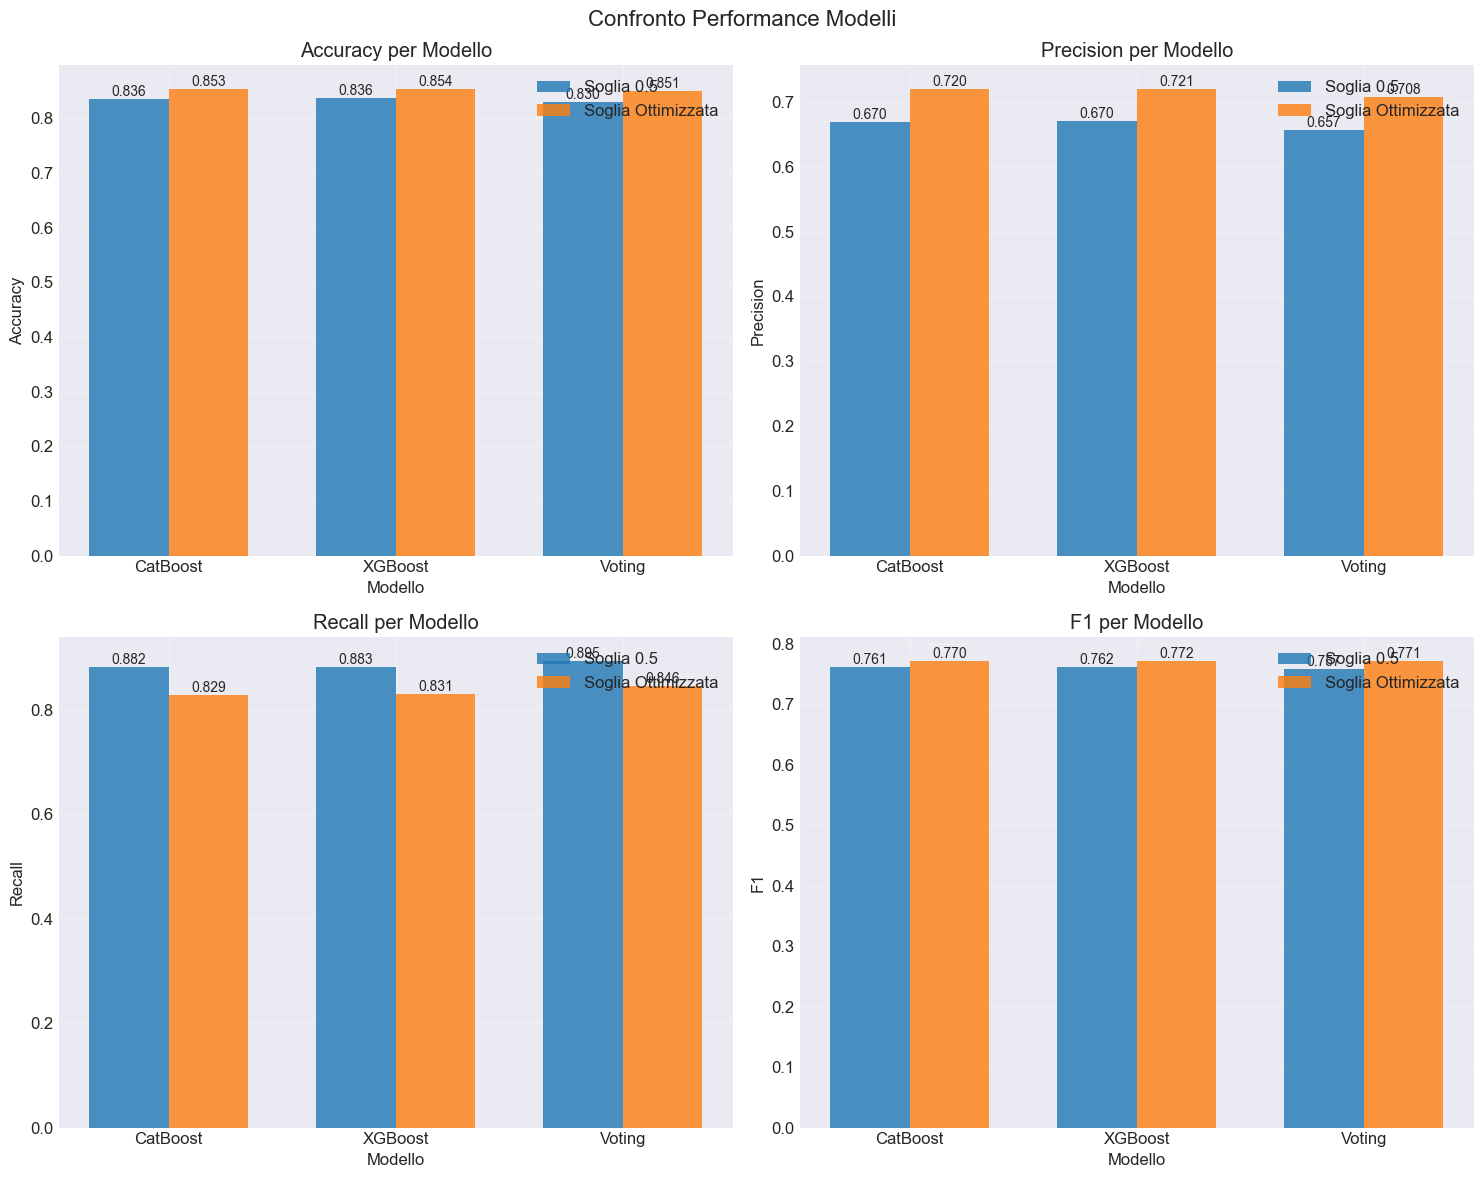

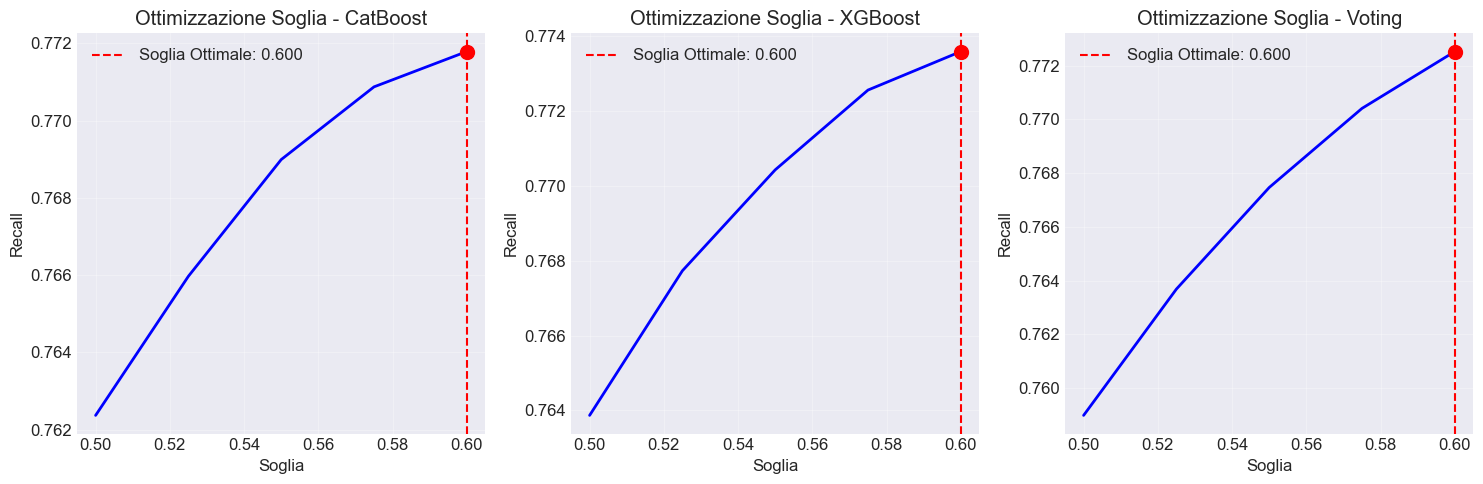

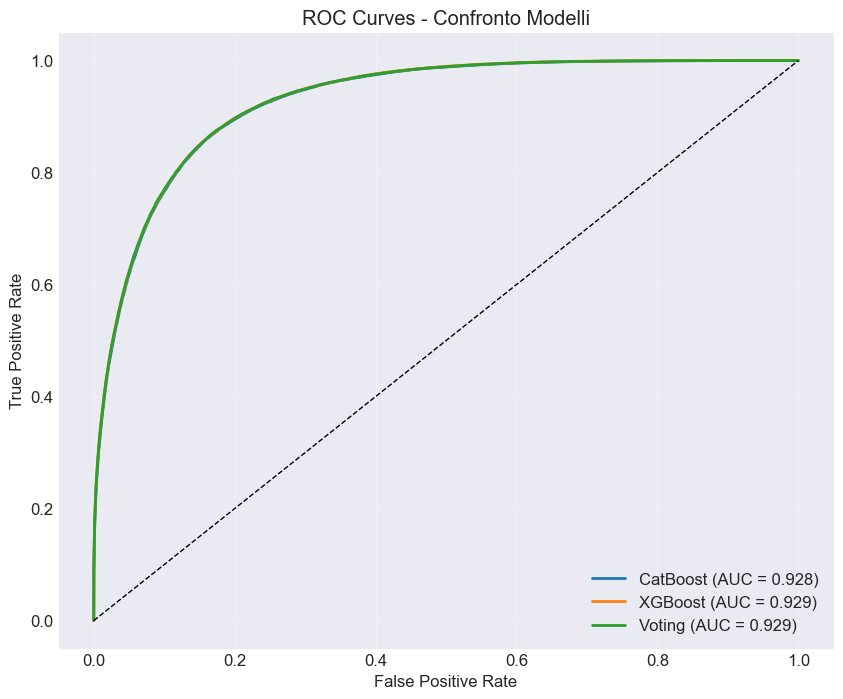

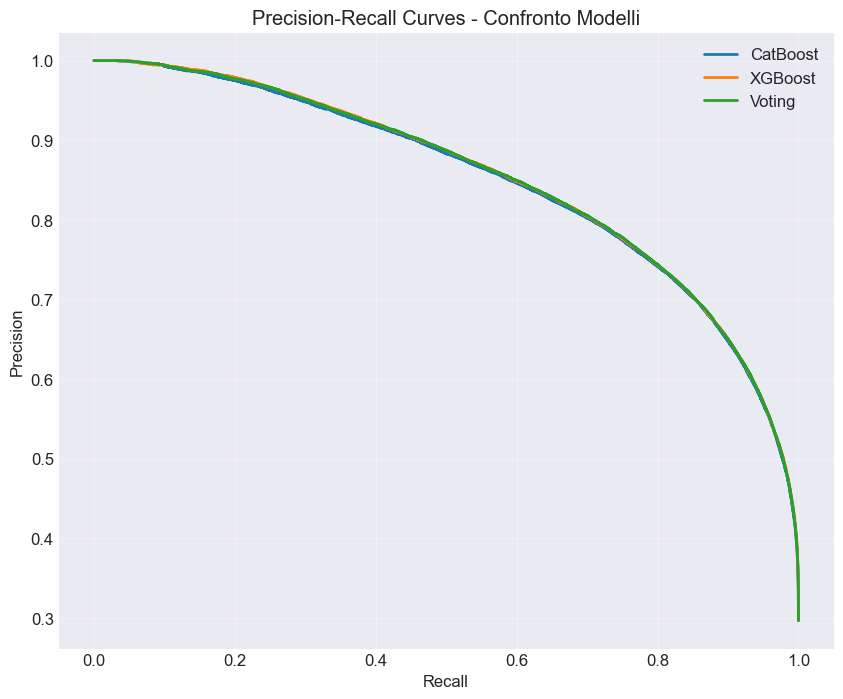

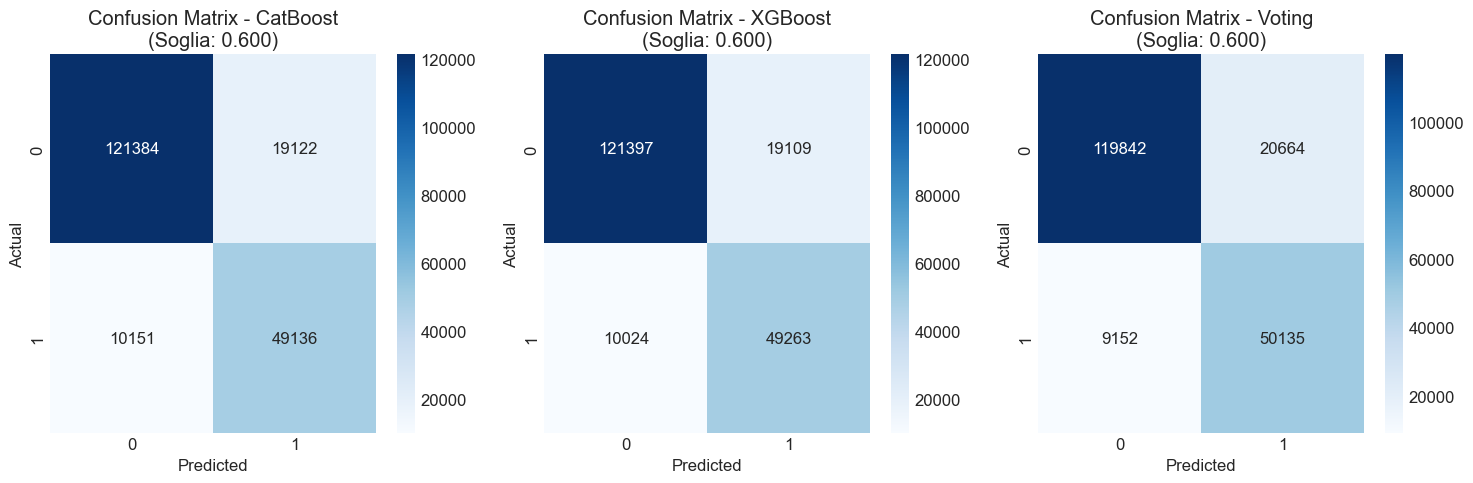


REPORT FINALE - CONFRONTO MODELLI

                 Modello Accuracy Precision Recall F1-Score AUC-ROC
  CatBoost (Soglia 0.5)   0.8359    0.6697 0.8819   0.7613  0.9279
CatBoost (Soglia 0.600)   0.8535    0.7199 0.8288   0.7705  0.9279
   XGBoost (Soglia 0.5)   0.8362    0.6699 0.8832   0.7619  0.9291
 XGBoost (Soglia 0.600)   0.8542    0.7205 0.8309   0.7718  0.9291
    Voting (Soglia 0.5)   0.8299    0.6566 0.8948   0.7574  0.9290
  Voting (Soglia 0.600)   0.8508    0.7081 0.8456   0.7708  0.9290

MIGLIORAMENTO DEL RECALL CON OTTIMIZZAZIONE SOGLIA

CatBoost:
  Recall prima: 0.8819
  Recall dopo:  0.8288
  Miglioramento: -6.0%

XGBoost:
  Recall prima: 0.8832
  Recall dopo:  0.8309
  Miglioramento: -5.9%

Voting:
  Recall prima: 0.8948
  Recall dopo:  0.8456
  Miglioramento: -5.5%

SALVATAGGIO CONFIGURAZIONE FINALE
✓ Voting Classifier salvato in './models/voting/voting_classifier_final.pkl
✓ Configurazione salvata in './models/voting/model_config.pkl
✓ Soglia ottimale per Recall: 0.

In [59]:

# 2. CUSTOM VOTING CLASSIFIER
class MaxProbVotingClassifier(BaseEstimator, ClassifierMixin):
    """
    Voting Classifier che seleziona la classe con la probabilità più alta.
    In caso di pareggio, privilegia CatBoost.
    """
    def __init__(self, estimators, scalers=None):
        self.estimators = estimators
        self.scalers = scalers if scalers else {}
        self.classes_ = np.array([0, 1])
        
    def fit(self, X, y):
        # Fit degli scaler se necessario
        for name, scaler in self.scalers.items():
            if scaler is not None and not hasattr(scaler, 'mean_'):
                scaler.fit(X)
        return self
    
    def predict_proba(self, X):
        """Calcola le probabilità medie o massime per ogni classe"""
        probas = []
        
        for name, model in self.estimators:
            if model is None:
                continue
                
            # Applica lo scaler se disponibile
            X_scaled = X
            if name in self.scalers and self.scalers[name] is not None:
                X_scaled = self.scalers[name].transform(X)
            
            # Ottieni le probabilità
            proba = model.predict_proba(X_scaled)
            probas.append((name, proba))
        
        if not probas:
            raise ValueError("Nessun modello disponibile per le predizioni")
        
        # Per ogni sample, prendi la probabilità massima per la classe positiva
        n_samples = X.shape[0]
        final_probas = np.zeros((n_samples, 2))
        
        for i in range(n_samples):
            max_prob_class_1 = -1
            best_model = None
            
            for name, proba in probas:
                if proba[i, 1] > max_prob_class_1:
                    max_prob_class_1 = proba[i, 1]
                    best_model = name
                    final_probas[i] = proba[i]
                elif proba[i, 1] == max_prob_class_1 and name == 'catboost':
                    # In caso di pareggio, privilegia CatBoost
                    best_model = name
                    final_probas[i] = proba[i]
        
        return final_probas
    
    def predict(self, X):
        """Predizione basata sulle probabilità"""
        probas = self.predict_proba(X)
        return (probas[:, 1] >= 0.5).astype(int)

# 3. PREPARAZIONE DATI
print("\nPreparazione dati...")
X_train, X_test, y_train, y_test = train_test_split(
    fit_data_with_features_clean, 
    labels_clean,
    test_size=0.2, 
    random_state=42, 
    stratify=labels_clean
)

print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
#print(f"Distribuzione classi train: {np.bincount(y_train)}")
#print(f"Distribuzione classi test: {np.bincount(y_test)}")

# 4. CREAZIONE VOTING CLASSIFIER
estimators = []
scalers = {}

if catboost_model_final is not None:
    estimators.append(('catboost', catboost_model_final))
    scalers['catboost'] = catboost_scaler

if xg_boost_model_final is not None:
    estimators.append(('xgboost', xg_boost_model_final))
    scalers['xgboost'] = xgboost_scaler

voting_clf = MaxProbVotingClassifier(estimators=estimators, scalers=scalers)
voting_clf.fit(X_train, y_train)

# 5. FUNZIONE PER TROVARE SOGLIA OTTIMALE
def find_optimal_threshold(model, X, y, metric='precision', conservative=False):
    """
    Trova la soglia ottimale per massimizzare una metrica.
    Se conservative=True, in caso di pareggio prende la soglia più bassa (più conservativa).
    """
    probas = model.predict_proba(X)[:, 1]
    thresholds = np.linspace(0.5, 0.6, 5)
    print(f"y_pred: {probas}")
    scores = []
    for threshold in thresholds:
        y_pred = (probas >= threshold).astype(int)
        print(f"y_pred: {y_pred}")
        
        if metric == 'recall':
            score = recall_score(y, y_pred)
        elif metric == 'precision':
            score = precision_score(y, y_pred)
        elif metric == 'f1':
            score = f1_score(y, y_pred)
        else:
            raise ValueError(f"Metrica non supportata: {metric}")
        
        scores.append(score)
    
    scores = np.array(scores)
    
    if conservative:
        # Trova il primo threshold che massimizza la metrica
        optimal_idx = np.where(scores == scores.max())[0][0]
    else:
        # Trova l'ultimo threshold che massimizza la metrica
        optimal_idx = np.where(scores == scores.max())[0][-1]
    
    optimal_threshold = thresholds[optimal_idx]
    optimal_score = scores[optimal_idx]
    
    return optimal_threshold, optimal_score, thresholds, scores

# 6. VALUTAZIONE MODELLI
def evaluate_model(model, X_test, y_test, model_name, threshold=0.5):
    """Valuta un modello con metriche multiple"""
    probas = model.predict_proba(X_test)[:, 1]
    y_pred = (probas >= threshold).astype(int)
    
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'auc': roc_auc_score(y_test, probas)
    }
    
    print(f"\n{model_name} - Soglia: {threshold:.3f}")
    print(f"Accuracy:  {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall:    {metrics['recall']:.4f}")
    print(f"F1-Score:  {metrics['f1']:.4f}")
    print(f"AUC-ROC:   {metrics['auc']:.4f}")
    
    return metrics, y_pred, probas

# Valutazione con soglia standard (0.5)
print("\n" + "="*50)
print("VALUTAZIONE MODELLI CON SOGLIA STANDARD (0.5)")
print("="*50)

results_standard = {}

# CatBoost
if catboost_model_final is not None:
    X_test_scaled_cb = catboost_scaler.transform(X_test) if catboost_scaler else X_test
    metrics, y_pred, probas = evaluate_model(
        catboost_model_final, X_test_scaled_cb, y_test, "CatBoost"
    )
    results_standard['CatBoost'] = {'metrics': metrics, 'y_pred': y_pred, 'probas': probas}

# XGBoost (se disponibile)
if xg_boost_model_final is not None:
    X_test_scaled_xgb = xgboost_scaler.transform(X_test) if xgboost_scaler else X_test
    metrics, y_pred, probas = evaluate_model(
        xg_boost_model_final, X_test_scaled_xgb, y_test, "XGBoost"
    )
    results_standard['XGBoost'] = {'metrics': metrics, 'y_pred': y_pred, 'probas': probas}

# Voting Classifier
metrics, y_pred, probas = evaluate_model(voting_clf, X_test, y_test, "Voting Classifier")
results_standard['Voting'] = {'metrics': metrics, 'y_pred': y_pred, 'probas': probas}

# 7. OTTIMIZZAZIONE SOGLIA PER f1
print("\n" + "="*50)
print("OTTIMIZZAZIONE SOGLIA PER MASSIMIZZARE f1")
print("="*50)

results_optimized = {}

# Trova soglie ottimali per ogni modello
for model_name, model in [('CatBoost', catboost_model_final), 
                          ('XGBoost', xg_boost_model_final),
                          ('Voting', voting_clf)]:
    if model is None:
        continue
    
    if model_name == 'CatBoost':
        X_val = catboost_scaler.transform(X_train) if catboost_scaler else X_train
        X_test_model = catboost_scaler.transform(X_test) if catboost_scaler else X_test
    elif model_name == 'XGBoost':
        X_val = xgboost_scaler.transform(X_train) if xgboost_scaler else X_train
        X_test_model = xgboost_scaler.transform(X_test) if xgboost_scaler else X_test
    else:  # Voting
        X_val = X_train
        X_test_model = X_test
    
    optimal_threshold, optimal_recall, thresholds, scores = find_optimal_threshold(
        model, X_val, y_train, metric='f1', conservative=True
    )
    
    print(f"\n{model_name}:")
    print(f"Soglia ottimale: {optimal_threshold:.3f}")
    print(f"f1 sul train: {optimal_recall:.4f}")
    
    # Valuta con soglia ottimale
    metrics, y_pred, probas = evaluate_model(
        model, X_test_model, y_test, f"{model_name} (Ottimizzato)", optimal_threshold
    )
    
    results_optimized[model_name] = {
        'metrics': metrics,
        'y_pred': y_pred,
        'probas': probas,
        'optimal_threshold': optimal_threshold,
        'threshold_scores': (thresholds, scores)
    }

# 8. VISUALIZZAZIONI

# 8.1 Confronto metriche
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Confronto Performance Modelli', fontsize=16)

# Prepara dati per confronto
models = list(results_standard.keys())
metrics_names = ['accuracy', 'precision', 'recall', 'f1']

for idx, metric in enumerate(metrics_names):
    ax = axes[idx//2, idx%2]
    
    standard_scores = [results_standard[m]['metrics'][metric] for m in models]
    optimized_scores = [results_optimized[m]['metrics'][metric] 
                       for m in models if m in results_optimized]
    
    x = np.arange(len(models))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, standard_scores, width, label='Soglia 0.5', alpha=0.8)
    bars2 = ax.bar(x + width/2, optimized_scores, width, label='Soglia Ottimizzata', alpha=0.8)
    
    ax.set_xlabel('Modello')
    ax.set_ylabel(metric.capitalize())
    ax.set_title(f'{metric.capitalize()} per Modello')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Aggiungi valori sulle barre
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# 8.2 Curve di ottimizzazione soglia
fig, axes = plt.subplots(1, len(results_optimized), figsize=(15, 5))
if len(results_optimized) == 1:
    axes = [axes]

for idx, (model_name, result) in enumerate(results_optimized.items()):
    thresholds, scores = result['threshold_scores']
    optimal_threshold = result['optimal_threshold']
    
    ax = axes[idx]
    ax.plot(thresholds, scores, 'b-', linewidth=2)
    ax.axvline(optimal_threshold, color='red', linestyle='--', 
               label=f'Soglia Ottimale: {optimal_threshold:.3f}')
    ax.scatter([optimal_threshold], [scores[np.where(thresholds == optimal_threshold)[0][0]]], 
               color='red', s=100, zorder=5)
    
    ax.set_xlabel('Soglia')
    ax.set_ylabel('Recall')
    ax.set_title(f'Ottimizzazione Soglia - {model_name}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 8.3 ROC Curves
plt.figure(figsize=(10, 8))

for model_name in results_standard.keys():
    if model_name in results_optimized:
        probas = results_optimized[model_name]['probas']
    else:
        probas = results_standard[model_name]['probas']
    
    fpr, tpr, _ = roc_curve(y_test, probas)
    auc = roc_auc_score(y_test, probas)
    
    plt.plot(fpr, tpr, linewidth=2, label=f'{model_name} (AUC = {auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Confronto Modelli')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 8.4 Precision-Recall Curves
plt.figure(figsize=(10, 8))

for model_name in results_standard.keys():
    if model_name in results_optimized:
        probas = results_optimized[model_name]['probas']
    else:
        probas = results_standard[model_name]['probas']
    
    precision, recall, _ = precision_recall_curve(y_test, probas)
    
    plt.plot(recall, precision, linewidth=2, label=model_name)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves - Confronto Modelli')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 8.5 Confusion Matrices
n_models = len(results_optimized)
fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 5))
if n_models == 1:
    axes = [axes]

for idx, (model_name, result) in enumerate(results_optimized.items()):
    cm = confusion_matrix(y_test, result['y_pred'])
    
    ax = axes[idx]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=True)
    ax.set_title(f'Confusion Matrix - {model_name}\n(Soglia: {result["optimal_threshold"]:.3f})')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()



# 9. REPORT FINALE
print("\n" + "="*50)
print("REPORT FINALE - CONFRONTO MODELLI")
print("="*50)

# Tabella riassuntiva
summary_data = []

for model_name in results_standard.keys():
    # Risultati con soglia standard
    std_metrics = results_standard[model_name]['metrics']
    row = {
        'Modello': f"{model_name} (Soglia 0.5)",
        'Accuracy': f"{std_metrics['accuracy']:.4f}",
        'Precision': f"{std_metrics['precision']:.4f}",
        'Recall': f"{std_metrics['recall']:.4f}",
        'F1-Score': f"{std_metrics['f1']:.4f}",
        'AUC-ROC': f"{std_metrics['auc']:.4f}"
    }
    summary_data.append(row)
    
    # Risultati con soglia ottimizzata
    if model_name in results_optimized:
        opt_metrics = results_optimized[model_name]['metrics']
        opt_threshold = results_optimized[model_name]['optimal_threshold']
        row = {
            'Modello': f"{model_name} (Soglia {opt_threshold:.3f})",
            'Accuracy': f"{opt_metrics['accuracy']:.4f}",
            'Precision': f"{opt_metrics['precision']:.4f}",
            'Recall': f"{opt_metrics['recall']:.4f}",
            'F1-Score': f"{opt_metrics['f1']:.4f}",
            'AUC-ROC': f"{opt_metrics['auc']:.4f}"
        }
        summary_data.append(row)

summary_df = pd.DataFrame(summary_data)
print("\n", summary_df.to_string(index=False))

# Miglioramento del Recall
print("\n" + "="*50)
print("MIGLIORAMENTO DEL RECALL CON OTTIMIZZAZIONE SOGLIA")
print("="*50)

for model_name in results_standard.keys():
    if model_name in results_optimized:
        recall_before = results_standard[model_name]['metrics']['recall']
        recall_after = results_optimized[model_name]['metrics']['recall']
        improvement = (recall_after - recall_before) / recall_before * 100
        
        print(f"\n{model_name}:")
        print(f"  Recall prima: {recall_before:.4f}")
        print(f"  Recall dopo:  {recall_after:.4f}")
        print(f"  Miglioramento: {improvement:+.1f}%")

# 10. SALVATAGGIO MODELLO FINALE E CONFIGURAZIONE
print("\n" + "="*50)
print("SALVATAGGIO CONFIGURAZIONE FINALE")
print("="*50)

# Salva il voting classifier e la configurazione ottimale
best_model_name = 'Voting'  # Puoi cambiare con il modello migliore
best_threshold = results_optimized[best_model_name]['optimal_threshold']

config = {
    'model_type': 'voting_classifier',
    'optimal_threshold': best_threshold,
    'models_included': list(dict(voting_clf.estimators).keys()),
    'performance_metrics': results_optimized[best_model_name]['metrics'],
    'scalers': {name: scaler for name, scaler in scalers.items() if scaler is not None}
}

# Salva il modello
joblib.dump(voting_clf, './models/voting/voting_classifier_final.pkl')
joblib.dump(config, './models/voting/model_config.pkl')

print("✓ Voting Classifier salvato in './models/voting/voting_classifier_final.pkl")
print("✓ Configurazione salvata in './models/voting/model_config.pkl")
print(f"✓ Soglia ottimale per Recall: {best_threshold:.3f}")
print(f"✓ Recall finale: {results_optimized[best_model_name]['metrics']['recall']:.4f}")

### DEEP TEST 

In [55]:
from collections import Counter
# Crea 10 subset bilanciati di 50000 campioni ciascuno e controllo integrità e distribuzione delle classi
num_subsets = 10
subset_size = 50000

subsets_X_filtered = []
subsets_y_filtered = []

# Trova gli indici delle due classi
idx_0 = np.where(labels_clean == 0)[0]
idx_1 = np.where(labels_clean == 1)[0]
min_class_size = min(len(idx_0), len(idx_1), subset_size // 2)

for i in range(num_subsets):
    idx_0_sample = np.random.choice(idx_0, size=min_class_size, replace=False)
    idx_1_sample = np.random.choice(idx_1, size=min_class_size, replace=False)
    idx_balanced = np.concatenate([idx_0_sample, idx_1_sample])
    np.random.shuffle(idx_balanced)
    subsets_X_filtered.append(fit_data_with_features_clean[idx_balanced])
    subsets_y_filtered.append(labels_clean[idx_balanced])


# Controlla la distribuzione delle classi in ogni subset
for i, (X, y) in enumerate(zip(subsets_X_filtered, subsets_y_filtered)):
    assert len(X) == subset_size, f"Subset {i+1} size mismatch: {len(X)} != {subset_size}"
    assert len(y) == subset_size, f"Subset {i+1} labels size mismatch: {len(y)} != {subset_size}"
    print(f"Subset {i+1}: {Counter(y)}")


# Check if all elements in subsets_X_unfiltered are different
all_unique = True
for i in range(num_subsets):
    for j in range(i + 1, num_subsets):
        if np.array_equal(subsets_X_filtered[i], subsets_X_filtered[j]):
            print(f"Subset {i+1} and Subset {j+1} are identical!")
            all_unique = False
if all_unique:
    print("All subsets in subsets_X_filtered are different.")

Subset 1: Counter({1: 25000, 0: 25000})
Subset 2: Counter({1: 25000, 0: 25000})
Subset 3: Counter({1: 25000, 0: 25000})
Subset 4: Counter({1: 25000, 0: 25000})
Subset 5: Counter({0: 25000, 1: 25000})
Subset 6: Counter({0: 25000, 1: 25000})
Subset 7: Counter({1: 25000, 0: 25000})
Subset 8: Counter({1: 25000, 0: 25000})
Subset 9: Counter({0: 25000, 1: 25000})
Subset 10: Counter({0: 25000, 1: 25000})
All subsets in subsets_X_filtered are different.


In [58]:
# TEST SU DATASET BILANCIATO (50K SAMPLES)
print("\n" + "="*70)
print("TEST SU DATASET BILANCIATO - 50.000 SAMPLES")
print("="*70)

# Assegna i nuovi dati di test
X_test_balanced = subsets_X_filtered
y_test_balanced = subsets_y_filtered

print(f"\nDimensioni test set bilanciato: {X_test_balanced.shape}")
#print(f"Distribuzione classi: {np.bincount(y_test_balanced)}")
#print(f"Bilanciamento: {np.bincount(y_test_balanced)[1] / len(y_test_balanced):.2%} classe positiva")

# Funzione per test esteso con analisi dettagliata
def extended_test_evaluation(model, X_test, y_test, model_name, threshold, scaler=None):
    """Valutazione estesa con analisi per sottogruppi"""
    
    # Applica scaler se necessario
    if scaler is not None:
        X_test_scaled = scaler.transform(X_test)
    else:
        X_test_scaled = X_test
    
    # Calcola probabilità e predizioni
    probas = model.predict_proba(X_test_scaled)[:, 1]
    y_pred = (probas >= threshold).astype(int)
    
    # Metriche generali
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'auc': roc_auc_score(y_test, probas)
    }
    
    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # Metriche aggiuntive
    specificity = tn / (tn + fp)
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    
    print(f"\n{model_name} - Test Set Bilanciato (Soglia: {threshold:.3f})")
    print("-" * 50)
    print(f"Accuracy:    {metrics['accuracy']:.4f}")
    print(f"Precision:   {metrics['precision']:.4f}")
    print(f"Recall:      {metrics['recall']:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1-Score:    {metrics['f1']:.4f}")
    print(f"AUC-ROC:     {metrics['auc']:.4f}")
    print(f"NPV:         {npv:.4f}")
    print("\nConfusion Matrix:")
    print(f"  TP: {tp:,}  FP: {fp:,}")
    print(f"  FN: {fn:,}  TN: {tn:,}")
    
    return {
        'metrics': metrics,
        'probas': probas,
        'y_pred': y_pred,
        'confusion_matrix': (tn, fp, fn, tp),
        'specificity': specificity,
        'npv': npv
    }

# Test tutti i modelli con soglie ottimizzate
results_balanced = {}

# CatBoost
if catboost_model_final is not None:
    threshold = results_optimized['CatBoost']['optimal_threshold']
    results = extended_test_evaluation(
        catboost_model_final, X_test_balanced, y_test_balanced, 
        "CatBoost", threshold, catboost_scaler
    )
    results_balanced['CatBoost'] = results

# XGBoost (se disponibile)
if xg_boost_model_final is not None:
    threshold = results_optimized['XGBoost']['optimal_threshold']
    results = extended_test_evaluation(
        xg_boost_model_final, X_test_balanced, y_test_balanced,
        "XGBoost", threshold, xgboost_scaler
    )
    results_balanced['XGBoost'] = results

# Voting Classifier
threshold = results_optimized['Voting']['optimal_threshold']
results = extended_test_evaluation(
    voting_clf, X_test_balanced, y_test_balanced,
    "Voting Classifier", threshold
)
results_balanced['Voting'] = results

# 12. VISUALIZZAZIONI PER TEST SET BILANCIATO

# 12.1 Confronto performance tra test set originale e bilanciato
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Confronto Performance: Test Set Originale vs Bilanciato (50K samples)', fontsize=16)

metrics_to_compare = ['accuracy', 'precision', 'recall', 'f1', 'auc', 'specificity']
models_to_compare = ['CatBoost', 'Voting']  # Aggiungi 'XGBoost' se disponibile

for idx, metric in enumerate(metrics_to_compare):
    ax = axes[idx//3, idx%3]
    
    x = np.arange(len(models_to_compare))
    width = 0.35
    
    # Valori dal test set originale
    original_values = []
    for model in models_to_compare:
        if model in results_optimized:
            if metric == 'specificity':
                # Calcola specificity per test originale
                cm = confusion_matrix(y_test, results_optimized[model]['y_pred'])
                tn, fp = cm[0, 0], cm[0, 1]
                spec = tn / (tn + fp)
                original_values.append(spec)
            else:
                original_values.append(results_optimized[model]['metrics'].get(metric, 0))
    
    # Valori dal test set bilanciato
    balanced_values = []
    for model in models_to_compare:
        if model in results_balanced:
            if metric == 'specificity':
                balanced_values.append(results_balanced[model]['specificity'])
            else:
                balanced_values.append(results_balanced[model]['metrics'].get(metric, 0))
    
    # Plot
    bars1 = ax.bar(x - width/2, original_values, width, label='Test Originale', alpha=0.8)
    bars2 = ax.bar(x + width/2, balanced_values, width, label='Test Bilanciato', alpha=0.8)
    
    ax.set_xlabel('Modello')
    ax.set_ylabel(metric.capitalize())
    ax.set_title(f'{metric.capitalize()}')
    ax.set_xticks(x)
    ax.set_xticklabels(models_to_compare)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Aggiungi valori
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# 12.2 Distribuzione delle probabilità nel test set bilanciato
fig, axes = plt.subplots(1, len(results_balanced), figsize=(15, 5))
if len(results_balanced) == 1:
    axes = [axes]

for idx, (model_name, result) in enumerate(results_balanced.items()):
    probas = result['probas']
    threshold = results_optimized[model_name]['optimal_threshold']
    
    ax = axes[idx]
    
    # Separa probabilità per classe
    probas_class_0 = probas[y_test_balanced == 0]
    probas_class_1 = probas[y_test_balanced == 1]
    
    # Box plot
    data = [probas_class_0, probas_class_1]
    bp = ax.boxplot(data, labels=['Classe 0', 'Classe 1'], patch_artist=True)
    
    # Colori
    colors = ['lightblue', 'lightcoral']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    # Soglia
    ax.axhline(threshold, color='green', linestyle='--', linewidth=2,
               label=f'Soglia: {threshold:.3f}')
    
    ax.set_ylabel('Probabilità Classe 1')
    ax.set_title(f'Distribuzione Probabilità - {model_name}\n(Test Set Bilanciato)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 12.3 Analisi errori per intervalli di confidenza
fig, axes = plt.subplots(1, len(results_balanced), figsize=(15, 6))
if len(results_balanced) == 1:
    axes = [axes]

for idx, (model_name, result) in enumerate(results_balanced.items()):
    probas = result['probas']
    y_pred = result['y_pred']
    
    ax = axes[idx]
    
    # Definisci intervalli di confidenza
    bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
    bin_labels = ['0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1.0']
    
    # Calcola errori per intervallo
    errors_by_bin = []
    counts_by_bin = []
    
    for i in range(len(bins)-1):
        mask = (probas >= bins[i]) & (probas < bins[i+1])
        if mask.sum() > 0:
            errors = (y_pred[mask] != y_test_balanced[mask]).mean()
            errors_by_bin.append(errors)
            counts_by_bin.append(mask.sum())
        else:
            errors_by_bin.append(0)
            counts_by_bin.append(0)
    
    # Plot
    x = np.arange(len(bin_labels))
    bars = ax.bar(x, errors_by_bin, alpha=0.7)
    
    # Aggiungi count sopra le barre
    for i, (bar, count) in enumerate(zip(bars, counts_by_bin)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'n={count:,}', ha='center', va='bottom', fontsize=9)
    
    ax.set_xlabel('Intervallo di Probabilità')
    ax.set_ylabel('Tasso di Errore')
    ax.set_title(f'Errori per Intervallo di Confidenza - {model_name}')
    ax.set_xticks(x)
    ax.set_xticklabels(bin_labels)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 12.4 Curve di calibrazione
from sklearn.calibration import calibration_curve

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Curve di calibrazione
ax1 = axes[0]
for model_name, result in results_balanced.items():
    probas = result['probas']
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_test_balanced, probas, n_bins=10
    )
    
    ax1.plot(mean_predicted_value, fraction_of_positives, 
             marker='o', linewidth=2, label=model_name)

ax1.plot([0, 1], [0, 1], 'k--', label='Perfettamente calibrato')
ax1.set_xlabel('Probabilità Media Predetta')
ax1.set_ylabel('Frazione di Positivi')
ax1.set_title('Curve di Calibrazione - Test Set Bilanciato')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Istogramma delle predizioni
ax2 = axes[1]
for model_name, result in results_balanced.items():
    probas = result['probas']
    ax2.hist(probas, bins=20, alpha=0.5, label=model_name, density=True)

ax2.set_xlabel('Probabilità Predetta')
ax2.set_ylabel('Densità')
ax2.set_title('Distribuzione delle Probabilità Predette')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 13. REPORT FINALE COMPARATIVO
print("\n" + "="*70)
print("REPORT FINALE - CONFRONTO TEST SET ORIGINALE VS BILANCIATO")
print("="*70)

# Crea tabella comparativa
comparison_data = []

for model_name in results_balanced.keys():
    # Test originale
    if model_name in results_optimized:
        orig = results_optimized[model_name]['metrics']
        comparison_data.append({
            'Modello': model_name,
            'Test Set': 'Originale',
            'Samples': len(y_test),
            'Accuracy': f"{orig['accuracy']:.4f}",
            'Precision': f"{orig['precision']:.4f}",
            'Recall': f"{orig['recall']:.4f}",
            'F1-Score': f"{orig['f1']:.4f}",
            'AUC-ROC': f"{orig['auc']:.4f}"
        })
    
    # Test bilanciato
    bal = results_balanced[model_name]['metrics']
    comparison_data.append({
        'Modello': model_name,
        'Test Set': 'Bilanciato',
        'Samples': len(y_test_balanced),
        'Accuracy': f"{bal['accuracy']:.4f}",
        'Precision': f"{bal['precision']:.4f}",
        'Recall': f"{bal['recall']:.4f}",
        'F1-Score': f"{bal['f1']:.4f}",
        'AUC-ROC': f"{bal['auc']:.4f}"
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n", comparison_df.to_string(index=False))

# Analisi delle differenze
print("\n" + "="*70)
print("ANALISI DELLE DIFFERENZE")
print("="*70)

for model_name in results_balanced.keys():
    if model_name in results_optimized:
        print(f"\n{model_name}:")
        
        # Calcola differenze
        for metric in ['accuracy', 'precision', 'recall', 'f1']:
            orig_val = results_optimized[model_name]['metrics'][metric]
            bal_val = results_balanced[model_name]['metrics'][metric]
            diff = bal_val - orig_val
            diff_pct = (diff / orig_val) * 100 if orig_val > 0 else 0
            
            print(f"  {metric.capitalize():12} Δ = {diff:+.4f} ({diff_pct:+.1f}%)")

# Raccomandazioni finali
print("\n" + "="*70)
print("RACCOMANDAZIONI FINALI")
print("="*70)

best_recall = max(results_balanced.items(), key=lambda x: x[1]['metrics']['recall'])
best_f1 = max(results_balanced.items(), key=lambda x: x[1]['metrics']['f1'])
best_balanced = max(results_balanced.items(), 
                   key=lambda x: x[1]['metrics']['recall'] * x[1]['metrics']['precision'])

print(f"\n✓ Miglior Recall: {best_recall[0]} ({best_recall[1]['metrics']['recall']:.4f})")
print(f"✓ Miglior F1-Score: {best_f1[0]} ({best_f1[1]['metrics']['f1']:.4f})")
print(f"✓ Miglior bilanciamento Precision-Recall: {best_balanced[0]}")

print("\nNOTE:")
print("- Il test set bilanciato fornisce una valutazione più robusta delle performance")
print("- Le differenze tra i due test set indicano quanto il modello sia sensibile")
print("  alla distribuzione delle classi")
print("- Per applicazioni critiche dove il Recall è fondamentale, considerare")
print("  l'uso di soglie ancora più conservative")


TEST SU DATASET BILANCIATO - 50.000 SAMPLES


AttributeError: 'list' object has no attribute 'shape'